Files already downloaded and verified


c:\ProgramData\miniconda3\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Inference: 100%|██████████| 157/157 [00:28<00:00,  5.54it/s]
C:\Users\Wuy19\AppData\Local\Temp\ipykernel_72400\2903817099.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selected_accuracies, y=selected_class_names, palette="viridis")


Top-3 Classes:
lawn_mower: 95.00%
chair: 94.00%
orange: 94.00%

Worst-3 Classes:
otter: 9.00%
porcupine: 8.00%
ray: 5.00%


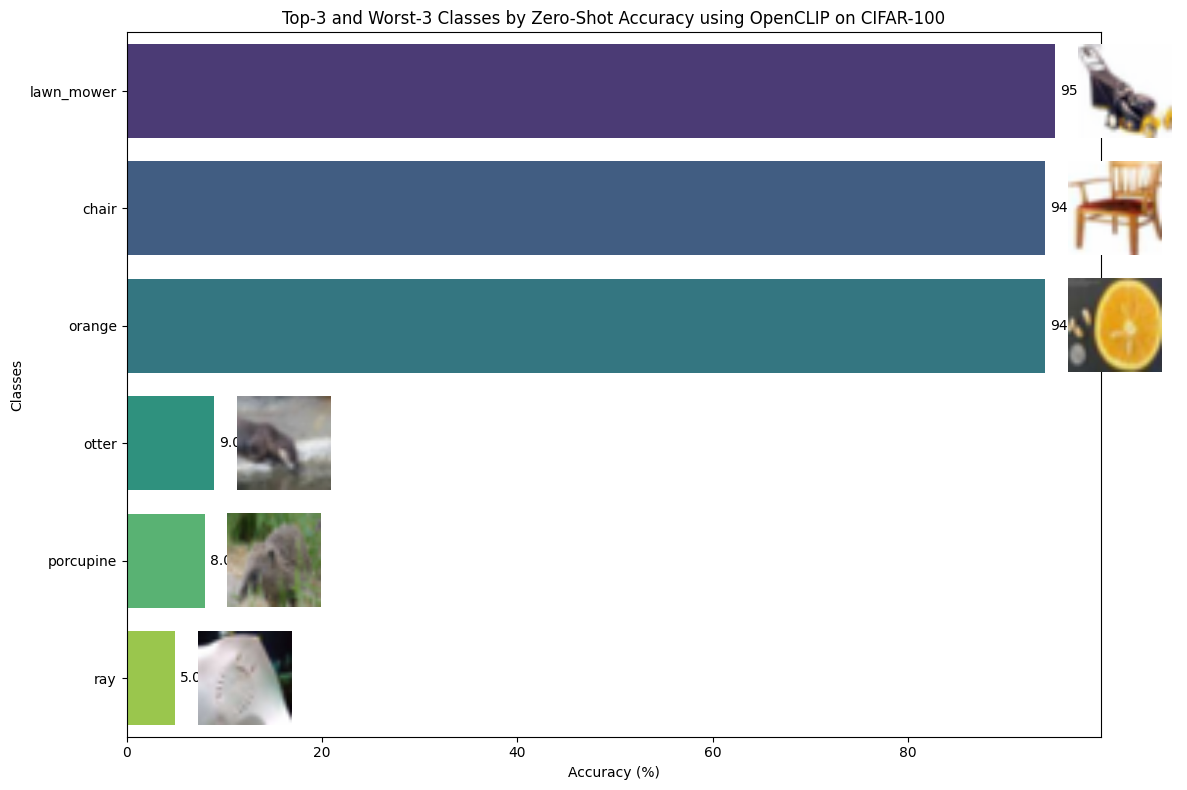

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import open_clip
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 1. Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # CLIP models typically expect 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

# 2. Load CIFAR-100 test set
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                             download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Get class names
cifar100_classes = test_dataset.classes

# 3. Load OpenCLIP model
model_name = "ViT-B-32"  # Choose your preferred model variant
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='openai')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 4. Prepare text prompts and compute text features
text_prompts = [f"a photo of a {classname}" for classname in cifar100_classes]
with torch.no_grad():
    tokenizer = open_clip.get_tokenizer(model_name)
    text_tokens = tokenizer(text_prompts).to(device)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# 5. Perform inference
all_preds = []
all_labels = []

for images, labels in tqdm(test_loader, desc="Inference"):
    images = images.to(device)
    with torch.no_grad():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = image_features @ text_features.t()
        preds = similarity.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# 6. Calculate per-class accuracy
correct_counts = defaultdict(int)
total_counts = defaultdict(int)

for pred, label in zip(all_preds, all_labels):
    total_counts[label] += 1
    if pred == label:
        correct_counts[label] += 1

per_class_accuracy = {}
for label in range(len(cifar100_classes)):
    if total_counts[label] > 0:
        per_class_accuracy[label] = correct_counts[label] / total_counts[label] * 100
    else:
        per_class_accuracy[label] = 0.0

# 7. Identify top-3 and worst-3 classes
sorted_classes = sorted(per_class_accuracy.items(), key=lambda x: x[1], reverse=True)
top_3 = sorted_classes[:3]
worst_3 = sorted_classes[-3:]

print("Top-3 Classes:")
for label, acc in top_3:
    print(f"{cifar100_classes[label]}: {acc:.2f}%")

print("\nWorst-3 Classes:")
for label, acc in worst_3:
    print(f"{cifar100_classes[label]}: {acc:.2f}%")

# 8. Visualization
selected_classes = top_3 + worst_3
selected_labels = [label for label, _ in selected_classes]
selected_accuracies = [acc for _, acc in selected_classes]
selected_class_names = [cifar100_classes[label] for label in selected_labels]

plt.figure(figsize=(12, 8))
sns.barplot(x=selected_accuracies, y=selected_class_names, palette="viridis")
plt.xlabel("Accuracy (%)")
plt.ylabel("Classes")
plt.title("Top-3 and Worst-3 Classes by Zero-Shot Accuracy using OpenCLIP on CIFAR-100")

# Annotate bars
for index, value in enumerate(selected_accuracies):
    plt.text(value + 0.5, index, f"{value:.2f}%", va='center')

# Function to get an example image for a class
def get_example_image(dataset, class_label):
    for img, label in dataset:
        if label == class_label:
            return img
    return None

# Add example images
ax = plt.gca()
for i, label in enumerate(selected_labels):
    img_tensor = get_example_image(test_dataset, label)
    if img_tensor is not None:
        img = img_tensor.permute(1, 2, 0).numpy()
        img = img * np.array([0.26862954, 0.26130258, 0.27577711]) + np.array([0.48145466, 0.4578275, 0.40821073])
        img = np.clip(img, 0, 1)
        img_pil = Image.fromarray((img * 255).astype(np.uint8))
        imagebox = OffsetImage(img_pil, zoom=0.3)
        ab = AnnotationBbox(imagebox, (selected_accuracies[i], i),
                            frameon=False, xybox=(50., 0.),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0.5,
                            )
        ax.add_artist(ab)

plt.tight_layout()
plt.show()


C:\Users\Wuy19\AppData\Local\Temp\ipykernel_72400\1580199272.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=selected_accuracies, y=selected_class_names, palette="viridis")


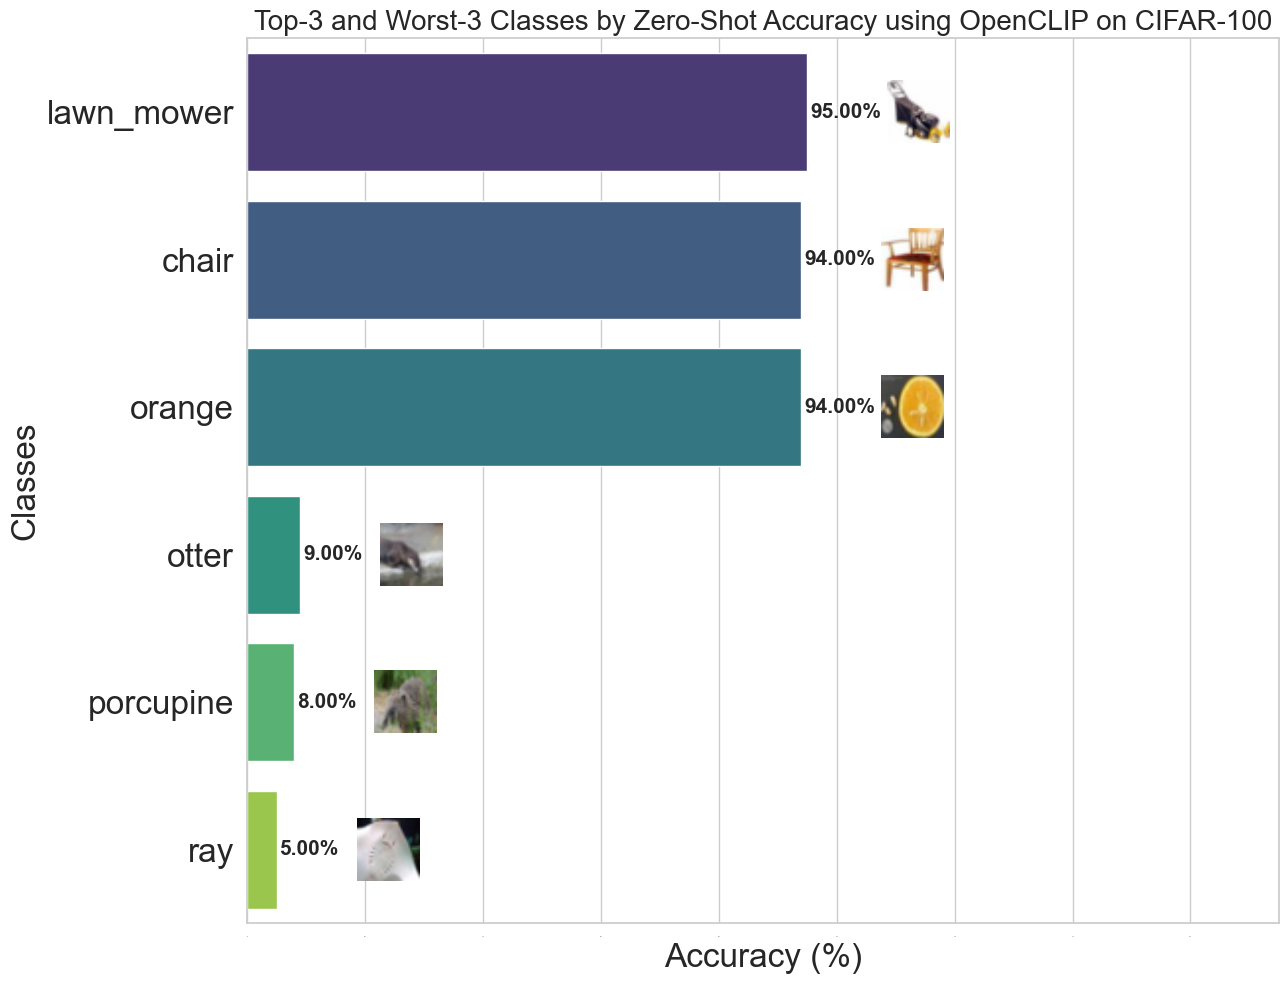

In [9]:
# 8. Visualization (Modified for Presentation)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Select top-3 and worst-3 classes
selected_classes = top_3 + worst_3
selected_labels = [label for label, _ in selected_classes]
selected_accuracies = [acc for _, acc in selected_classes]
selected_class_names = [cifar100_classes[label] for label in selected_labels]

# Set up the matplotlib figure with increased size for better visibility
plt.figure(figsize=(14, 10))

# Create a horizontal bar plot with larger fonts
sns.set(style="whitegrid")  # Set a clean style
bar_plot = sns.barplot(x=selected_accuracies, y=selected_class_names, palette="viridis")

# Increase font sizes for labels and title
plt.xlabel("Accuracy (%)", fontsize=24)
plt.ylabel("Classes", fontsize=24)
plt.title("Top-3 and Worst-3 Classes by Zero-Shot Accuracy using OpenCLIP on CIFAR-100", fontsize=20)

# Increase font size for y-axis tick labels
plt.yticks(fontsize=24)

# Increase font size for x-axis tick labels
plt.xticks(fontsize=0)

# Annotate bars with accuracy values using larger font
for index, value in enumerate(selected_accuracies):
    plt.text(value + 0.5, index, f"{value:.2f}%", va='center', fontsize=15, fontweight='bold')

# Function to get an example image for a class
def get_example_image(dataset, class_label):
    for img, label in dataset:
        if label == class_label:
            return img
    return None

# Add example images to the plot with adjusted placement and size
ax = plt.gca()
for i, label in enumerate(selected_labels):
    img_tensor = get_example_image(test_dataset, label)
    if img_tensor is not None:
        # Denormalize the image
        img = img_tensor.permute(1, 2, 0).numpy()
        img = img * np.array([0.26862954, 0.26130258, 0.27577711]) + np.array([0.48145466, 0.4578275, 0.40821073])
        img = np.clip(img, 0, 1)

        # Convert to PIL Image
        img_pil = Image.fromarray((img * 255).astype(np.uint8))

        # Create an image box with a smaller zoom factor
        imagebox = OffsetImage(img_pil, zoom=0.2)  # Reduced zoom to prevent overlap

        # Calculate new position for the image to the right of the bar
        # Adjust xybox to position images further away from the bars
        ab = AnnotationBbox(
            imagebox,
            (selected_accuracies[i], i),
            frameon=False,
            xybox=(80., 0.),  # Increased horizontal offset
            xycoords='data',
            boxcoords="offset points",
            pad=0.3,
        )

        ax.add_artist(ab)

# Adjust layout to accommodate images without clipping
plt.tight_layout()

# Optionally, adjust the plot limits to ensure images are fully visible
max_accuracy = max(selected_accuracies)
plt.xlim(0, max_accuracy + 80)  # Increased x-axis limit based on image offset

plt.show()
